In [65]:
import arviz as az
import pandas as pd
import numpy as np
import sqlite3
import os
import pprint
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from helper import *
import bambi as bmb
import pymc as pm
from multiprocessing import cpu_count

pp = pprint.PrettyPrinter(indent=2)

%matplotlib inline

# Data Collection

In [40]:
current_folder = os.path.abspath('')
db_file = os.path.join(current_folder, r"data/data.db")
db = sqlite3.connect(db_file)

In [145]:
query = r""" 
    SELECT events, launch_angle, launch_speed, estimated_ba_using_speedangle, hc_x, hc_y, hit_distance_sc, stand, bb_type
    FROM statcast
    WHERE type = 'X' AND
        events NOT LIKE 'sac_%'
"""
raw_data = pd.read_sql_query(query, db)

In [42]:
data = raw_data.copy()
hit_events = {
    'single':1,
    'double':2,
    'triple':3,
    'home_run':4
}

data = data.dropna(axis='index')
data['is_hit'] = np.where(data['events'].isin(hit_events.keys()), 1, 0)
data['bases_earned'] = data.apply(get_bases_earned, axis='columns')
data['spray_angle'] = data.apply(get_spray_angle, axis='columns')

In [31]:
rng = np.random.RandomState(seed=6420)
X_train, X_test, y_train, y_test = train_test_split(data.drop("is_hit", axis="columns"), data["is_hit"], test_size = 0.3, random_state=rng)

# Standard Logisitic Regression

{ 'Accuracy': 0.6842700258397932,
  'F1 Score': 0.1747572815533981,
  'Sensitivity': 0.10157016683022571,
  'Specificity': 0.9701492537313433}


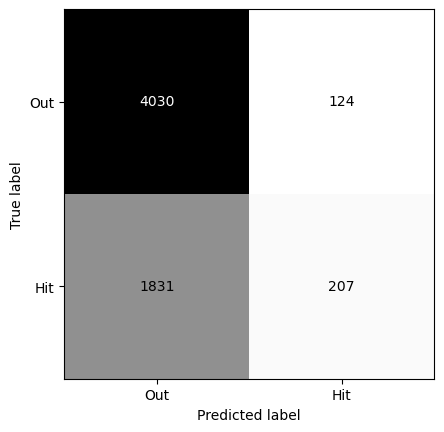

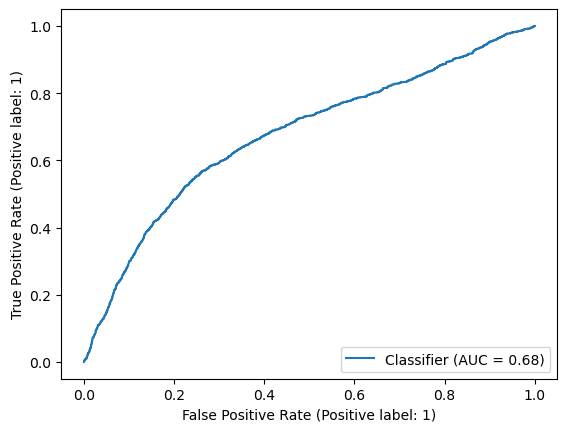

In [101]:
speed_angle_train = X_train[["launch_speed", "launch_angle"]]
# speed_angle_train["interaction"] = speed_angle_train["launch_angle"] * speed_angle_train["launch_speed"]
speed_angle_test = X_test[["launch_speed", "launch_angle"]]
# speed_angle_test["interaction"] = speed_angle_test["launch_angle"] * speed_angle_test["launch_speed"]
logit_model = LogisticRegression().fit(speed_angle_train, y_train)
logit_pred = logit_model.predict_proba(speed_angle_test)
logit_pred = [p[1] for p in logit_pred]

ConfusionMatrixDisplay.from_predictions(y_test, np.round(logit_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, logit_pred);
pp.pprint(cm_scores(y_test, np.round(logit_pred)))

# Bayesian Model

In [72]:
with pm.Model() as speed_angle_bayes_model:
    launch_angle = pm.Data("launch_angle", X_train["launch_angle"], mutable=True)
    exit_velo = pm.Data("exit_velo", X_train["launch_speed"], mutable=True)
    is_hit = pm.Data("is_hit", y_train, mutable=False)

    b0_intercept = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1_angle = pm.Normal("b1_launch_angle", mu=0, sigma=10)
    b2_velo = pm.Normal("b2_exit_velo", mu=0, sigma=10)

    p = b0_intercept + b1_angle * launch_angle + b2_velo * exit_velo

    likelihood = pm.Bernoulli("hit_probability", logit_p=p, observed=is_hit, shape=p.shape)

    trace = pm.sample(2000, cores=cpu_count())


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0_intercept, b1_launch_angle, b2_exit_velo]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 303 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [73]:
with speed_angle_bayes_model:
    pm.set_data({
        "launch_angle":X_test["launch_angle"],
        "exit_velo":X_test["launch_speed"]
    })
    ppc = pm.sample_posterior_predictive(trace, predictions=True)

{ 'Accuracy': 0.6828165374677002,
  'F1 Score': 0.1699070160608622,
  'Sensitivity': 0.0986261040235525,
  'Specificity': 0.9694270582571016}


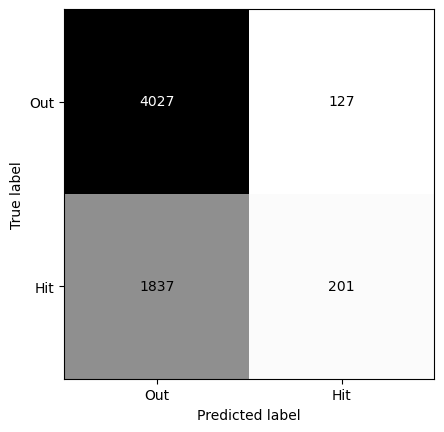

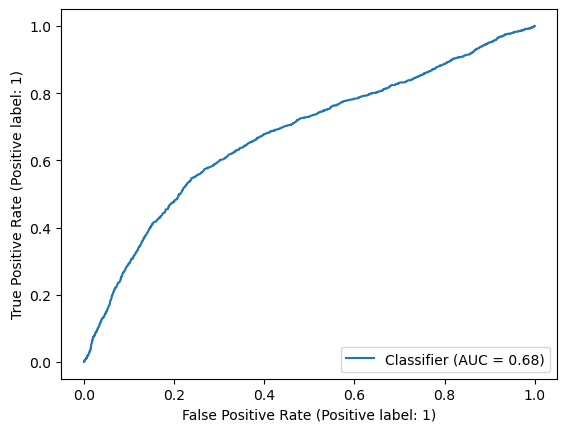

In [102]:
bayes_pred = ppc.predictions.hit_probability.mean(dim=["chain", "draw"])
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred);
pp.pprint(cm_scores(y_test, np.round(bayes_pred)))

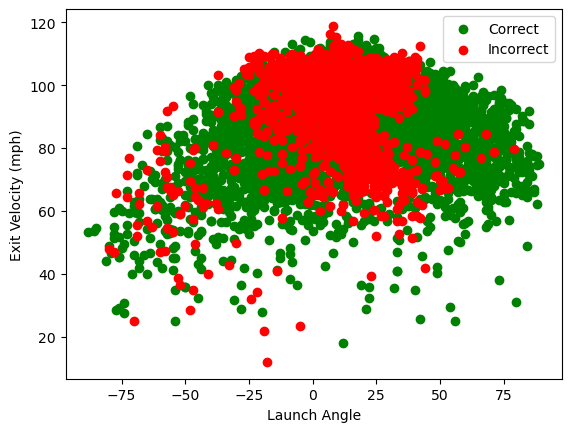

In [141]:
test_with_results = y_test == np.round(bayes_pred)
test_with_results.name="correct"
test_with_results = pd.concat([test_with_results, y_test, X_test], axis="columns")
correct_pred = test_with_results[test_with_results["correct"]]
incorrect_pred = test_with_results[~test_with_results['correct']]
plt.scatter(correct_pred['launch_angle'], correct_pred['launch_speed'], c="green",label="Correct")
plt.scatter(incorrect_pred['launch_angle'], incorrect_pred['launch_speed'], c="red",label="Incorrect")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();


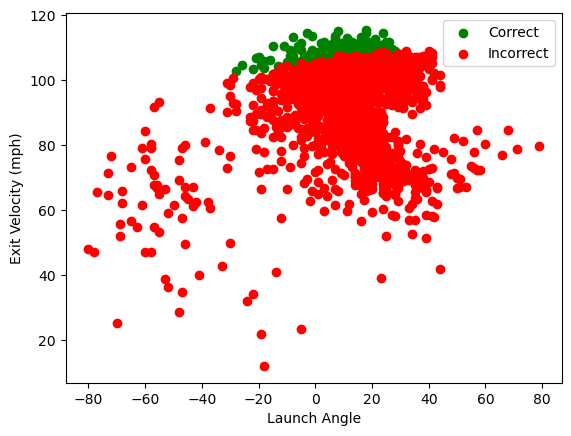

In [144]:
correct_hit_pred = test_with_results[test_with_results["correct"] & test_with_results["is_hit"]]
incorrect_hit_pred = test_with_results[~test_with_results['correct'] & test_with_results["is_hit"]]
plt.scatter(correct_hit_pred['launch_angle'], correct_hit_pred['launch_speed'], c="green",label="Correct")
plt.scatter(incorrect_hit_pred['launch_angle'], incorrect_hit_pred['launch_speed'], c="red",label="Incorrect")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();
